In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
# Load model outputs
parameters_all = pandas.read_csv('Optimized param - final.csv')
seeding_all = pandas.read_csv('Optimized seed - final.csv')

## Post Processing

In [3]:
# Eliminate ml_stage 0 subjects 
parameters_nonzero = parameters_all[parameters_all['ml_stage'] != 0]
seeding_nonzero = seeding_all[seeding_all['ml_stage'] != 0]

# Eliminate subjects with beta > 0.005
rids_to_remove = parameters_nonzero[parameters_nonzero['beta'] < 0.005]['RID'] # SET HERE
parameters_nonzero = parameters_nonzero[~parameters_nonzero['RID'].isin(rids_to_remove)]
seeding_nonzero = seeding_nonzero[~seeding_nonzero['RID'].isin(rids_to_remove)]

# Print value count for diagnostic categories
seeding_nonzero.Diagnosis.value_counts()


Diagnosis
0    85
1    73
2    53
Name: count, dtype: int64

In [66]:
# Sort by diagnosis 
CN_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 0]
MCI_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 1]
AD_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 2]
CN_by_stage_param = CN_param.sort_values(by='ml_stage')
MCI_by_stage_param = MCI_param.sort_values(by='ml_stage')
AD_by_stage_param = AD_param.sort_values(by='ml_stage')
parameters_by_diagnosis = pandas.concat([CN_by_stage_param, MCI_by_stage_param, AD_by_stage_param], ignore_index=True)

CN_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 0]
MCI_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 1]
AD_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 2]
CN_by_stage_seed = CN_seed.sort_values(by='ml_stage')
MCI_by_stage_seed = MCI_seed.sort_values(by='ml_stage')
AD_by_stage_seed = AD_seed.sort_values(by='ml_stage')
seeding_by_diagnosis = pandas.concat([CN_by_stage_seed, MCI_by_stage_seed, AD_by_stage_seed], ignore_index=True)

# Calculate column means
means_param = parameters_by_diagnosis.mean(numeric_only=True).to_frame().T
means_seed = seeding_by_diagnosis.mean(numeric_only=True).to_frame().T

## Plotting

# Parameter Optimization

   Unnamed: 0          RID  Diagnosis  ml_stage       MSE         R     alpha  \
0  301.696682  4889.824645   0.848341  4.943128  0.455669  0.061358  0.250833   

       beta    gamma    s    b    p          k  
0  0.979244  0.61877  0.5  0.0  0.0  19.999995  


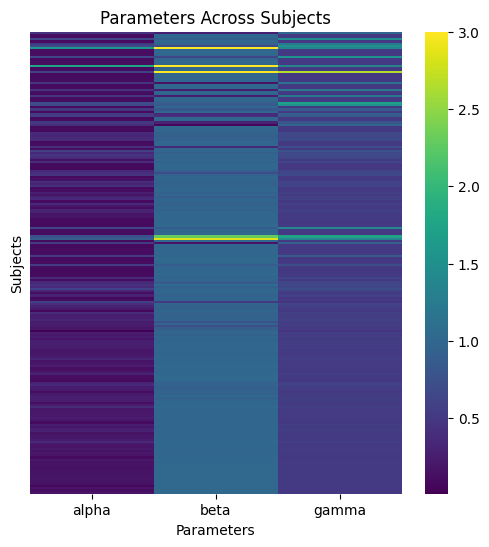

In [53]:
# Plot heat map of parameter values across subjects
plt.figure(figsize=(6, 6)) 
sns.heatmap(parameters_by_diagnosis.iloc[:,6:9], cmap='viridis', yticklabels=False)
plt.xlabel('Parameters')
plt.ylabel('Subjects')
plt.title('Parameters Across Subjects')

# Print average parameter values
print(means_param)

Text(0.5, 1.0, 'Alpha Histogram for Parameter Optimization')

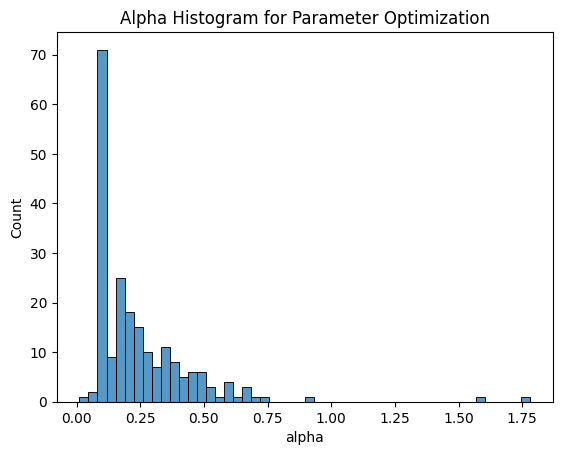

In [30]:
# Alpha histogram
sns.histplot(parameters_nonzero['alpha'], bins=50, kde=False)
plt.xlabel('alpha')
plt.ylabel('Count')
plt.title('Alpha Histogram for Parameter Optimization')
#plt.xlim(0, 3)
#plt.ylim(0, 450)

Text(0.5, 1.0, 'Beta Histogram for Parameter Optimization')

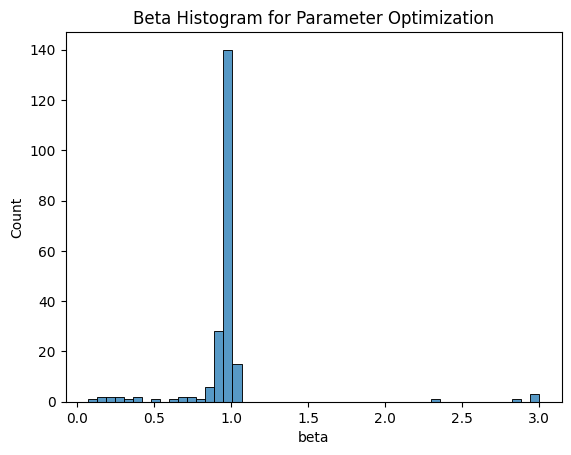

In [31]:
# Beta histogram
sns.histplot(parameters_nonzero['beta'], bins=50, kde=False)
plt.xlabel('beta')
plt.ylabel('Count')
plt.title('Beta Histogram for Parameter Optimization')
#plt.xlim(0, 3)
#plt.ylim(0, 450)

(0.0, 60.0)

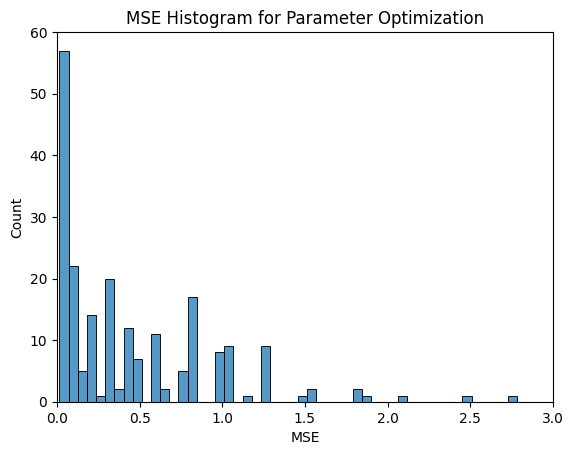

In [57]:
# Create histogram of MSE 
sns.histplot(parameters_nonzero['MSE'], bins=50, kde=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Parameter Optimization')
plt.xlim(0, 3)
plt.ylim(0, 60)

(0.0, 60.0)

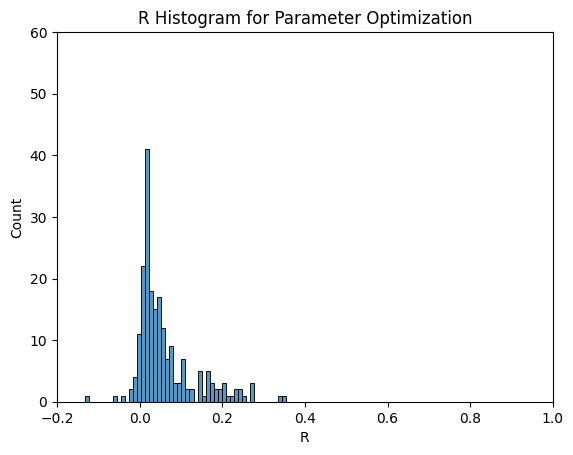

In [41]:
# Histogram for R
sns.histplot(parameters_nonzero['R'], bins=50, kde=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('R Histogram for Parameter Optimization')
plt.xlim(-0.2, 1)
plt.ylim(0, 60)

# Seed Optimization

Regions with highest average tau seed density: ['ctx-rh-middletemporal', 'ctx-lh-entorhinal', 'ctx-rh-bankssts', 'ctx-rh-entorhinal', 'ctx-rh-inferiorparietal', 'ctx-rh-superiortemporal', 'ctx-lh-superiorfrontal', 'ctx-rh-isthmuscingulate', 'ctx-lh-inferiortemporal', 'ctx-lh-isthmuscingulate', 'ctx-lh-caudalanteriorcingulate', 'ctx-rh-caudalanteriorcingulate', 'ctx-lh-lateralorbitofrontal', 'ctx-lh-transversetemporal', 'ctx-rh-parahippocampal', 'ctx-lh-lateraloccipital', 'ctx-lh-inferiorparietal', 'Left-VentralDC', 'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralanteriorcingulate', 'ctx-rh-inferiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-rostralanteriorcingulate', 'ctx-lh-parahippocampal', 'ctx-lh-fusiform', 'ctx-rh-transversetemporal', 'Left-Hippocampus', 'Left-Thalamus-Proper', 'ctx-rh-superiorfrontal', 'ctx-lh-pericalcarine', 'Right-Cerebellum-Cortex', 'Right-VentralDC', 'ctx-lh-lingual', 'ctx-rh-pericalcarine', 'ctx-rh-lateralorbitofrontal', 'ctx-rh-medialorbitofrontal', 'ctx-lh-p

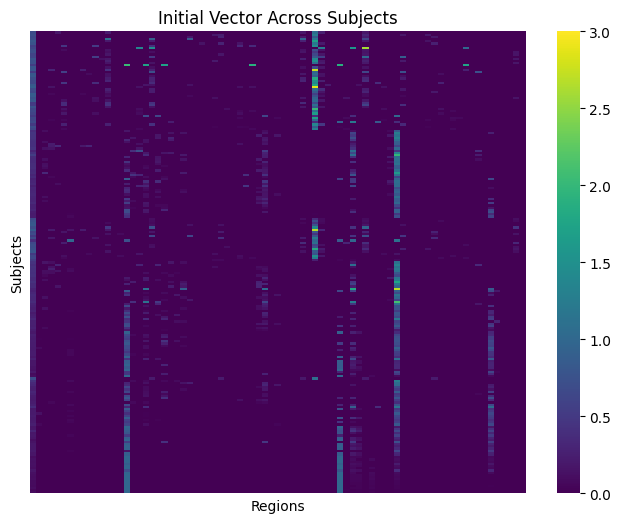

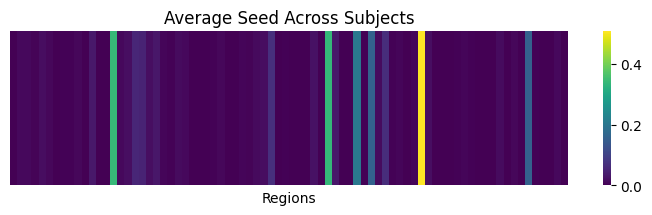

In [47]:
# Plot heat map of seeds across subjects
plt.figure(figsize=(8, 6)) 
sns.heatmap(seeding_by_diagnosis.iloc[:,5:], cmap='viridis', xticklabels=False, yticklabels=False, vmin=0, vmax=3)
plt.xlabel('Regions')
plt.ylabel('Subjects')
plt.title('Initial Vector Across Subjects')

# Plot average seed 
plt.figure(figsize=(9, 2)) 
sns.heatmap(means_seed.iloc[:, 6:], cmap='viridis', xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.title('Average Seed Across Subjects')

#Sort regions by highest averages and print
sorted_regions = means_seed.iloc[:, 6:].sort_values(by=0, axis=1, ascending=False)
sorted_regions = sorted_regions.columns.tolist()
print('Regions with highest average tau seed density: ' + str(sorted_regions))


(0.0, 60.0)

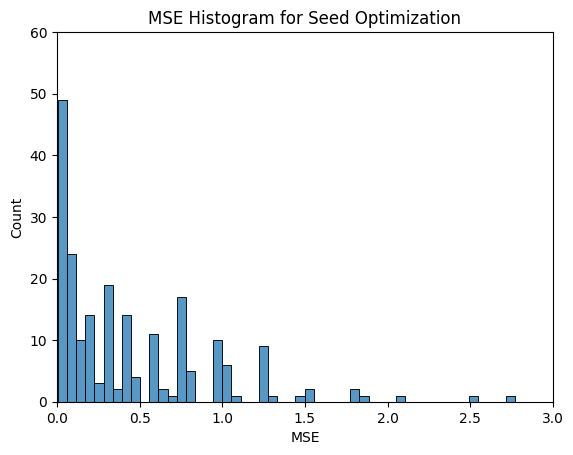

In [56]:
# Create histogram of MSE 
sns.histplot(seeding_nonzero['MSE'], bins=50, kde=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Seed Optimization')
plt.xlim(0, 3)
plt.ylim(0, 60)

(0.0, 60.0)

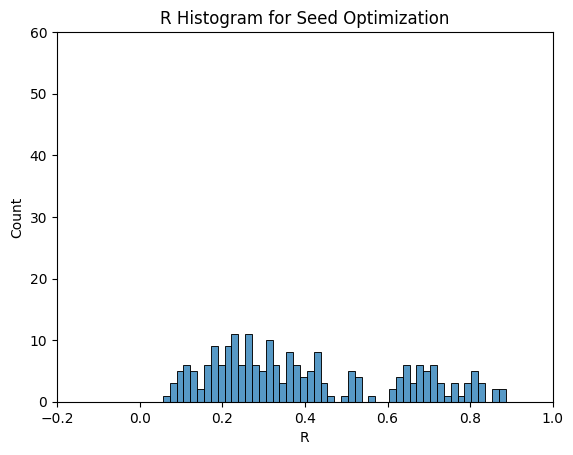

In [50]:
# Histogram of R 
sns.histplot(seeding_nonzero['R'], bins=50, kde=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('R Histogram for Seed Optimization')
plt.xlim(-0.2, 1)
plt.ylim(0, 60)

## Means and Variance

In [59]:
# Define mean MSE and Pearson's R
mean_mse_param = means_param['MSE'].iloc[0]
print('Mean MSE Parameter Optimization: ' + str(mean_mse_param))
mean_R_param = means_param['R'].iloc[0]
print('Mean R Parameter Optimization: ' + str(mean_R_param))

mean_mse_seed = means_seed['MSE'].iloc[0]
print('Mean MSE Seed Optimization: ' + str(mean_mse_seed))
mean_R_seed = means_seed['R'].iloc[0]
print('Mean R Seed Optimization: ' + str(mean_R_seed))

Mean MSE Parameter Optimization: 0.4556685258094538
Mean R Parameter Optimization: 0.06135763137434581
Mean MSE Seed Optimization: 0.4496144585738471
Mean R Seed Optimization: 0.39810385014726357


In [78]:
# Calucate the variance for seeds and parameters to explore heterogeniety within the population
variance_parameters = parameters_nonzero.var(numeric_only=True).to_frame().T
variance_average_parameters = variance_parameters[['alpha', 'beta', 'gamma']].mean(axis=1)
variance_seeds = seeding_nonzero.var(numeric_only=True).to_frame().T
variance_average_seed = variance_seeds.iloc[:, 5:].mean(axis=1)

print('Variance Parameter Optimization: ' + str(variance_average_parameters))
print('Variance Seed Optimization: ' + str(variance_average_seed))


Variance Parameter Optimization: 0    0.077972
dtype: float64
Variance Seed Optimization: 0    0.017574
dtype: float64


## Calcuating AIC

In [54]:
# Number of parameters being optimized
k_param = 3 # alpha, beta, gamma
k_seed = 6 # top 6 seeds

# Number of observations
n = len(seeding_nonzero)

# Compute the log-likelihood for both models
log_likelihoods_param = []
log_likelihoods_seed = []


for i in range(len(seeding_nonzero)): # for every subject
    subject_param = parameters_nonzero.iloc[i]
    log_likelihood_param = n / 2 * np.log(subject_param['R'] ** 2)
    log_likelihoods_param.append(log_likelihood_param)

    subject_seed = seeding_nonzero.iloc[i]
    log_likelihood_seed = n / 2 * np.log(subject_seed['R'] ** 2)
    log_likelihoods_seed.append(log_likelihood_seed)

# Sum log likelihoods across all subjects for both models
log_likelihoods_param = np.array(log_likelihoods_param)
log_total_param = log_likelihoods_param.sum()
log_likelihoods_seed = np.array(log_likelihoods_seed)
log_total_seed = log_likelihoods_seed.sum()

# Calculate AIC for both models
AIC_param = -2 * log_total_param + 2 * k_param
AIC_seed = -2 * log_total_seed + 2 * k_seed

print('AIC parameter optimization: ' + str(AIC_param))
print('AIC seed optimization: ' + str(AIC_seed))

AIC parameter optimization: 298151.29795106396
AIC seed optimization: 97221.4280441225
